In [1]:
import numpy as np
import pandas as pd
import os
import torch

In [2]:
csv_list = os.listdir("train")

df = pd.DataFrame()

for file in csv_list:
    if file.endswith(".csv"):
        df_temp = pd.read_csv(f"train/{file}")
        df = pd.concat([df, df_temp])
        
df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,10,2024-03-01 17:14:06.000,0.0,1017.48,15.59,94.30,652.92,0.12
1,10,2024-03-01 17:14:47.000,0.0,1017.48,15.66,94.04,682.50,0.12
2,10,2024-03-01 17:15:47.000,0.0,1017.47,15.74,94.10,750.00,0.14
3,10,2024-03-01 17:16:47.000,0.0,1017.46,15.78,94.09,738.33,0.14
4,10,2024-03-01 17:17:47.000,0.0,1017.49,15.80,94.08,660.83,0.12
...,...,...,...,...,...,...,...,...
89607,9,2024-07-23 15:50:57.000,0.0,994.54,30.69,72.91,2288.33,1.10
89608,9,2024-07-23 15:51:57.000,0.0,994.40,30.27,73.16,3236.67,1.92
89609,9,2024-07-23 15:52:57.000,0.0,994.39,29.90,72.51,4526.67,3.57
89610,9,2024-07-23 15:53:57.000,0.0,994.40,29.38,73.23,4231.67,3.13


In [3]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

encoder = ce.LeaveOneOutEncoder(cols=["LocationCode"], sigma = 0.05)
encoder.fit(df, df['Power(mW)'])
df = encoder.transform(df)

# 指定要標準化的欄位
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', "LocationCode"]

# 初始化 StandardScaler
scaler = StandardScaler()

# 對指定欄位進行標準化
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

df['DateTime'] = pd.to_datetime(df['DateTime'])


In [4]:

def mean_10min(df):
    location = df["LocationCode"].unique()
    new_df = pd.DataFrame()
    
    for l in location:
        l_df = df[df["LocationCode"] == l]
        l_df.set_index('DateTime', inplace=True)
        l_df = l_df.resample('10min').mean().dropna()  # 將 '10T' 改為 '10min'
        l_df = l_df.reset_index()
        l_df["LocationCode"] = l  # 添加 LocationCode 列
        #l_df = l_df.drop(columns=["DateTime", "LocationCode"])  # 如果不需要 DateTime 列的話可以刪除
        
        # 將 l_df 與 new_df 合併
        new_df = pd.concat([new_df, l_df], ignore_index=True)
    
    return new_df

df = mean_10min(df)





In [5]:
df["DateTime"]

0        2024-03-01 17:10:00
1        2024-03-01 17:20:00
2        2024-03-01 17:30:00
3        2024-03-01 17:40:00
4        2024-03-01 17:50:00
                 ...        
131750   2024-07-23 15:10:00
131751   2024-07-23 15:20:00
131752   2024-07-23 15:30:00
131753   2024-07-23 15:40:00
131754   2024-07-23 15:50:00
Name: DateTime, Length: 131755, dtype: datetime64[ns]

In [6]:
def spilt_data_with_datetime(df: pd.DataFrame):
    op_df = list(df['DateTime'].dt.day)
    
    data_df = df.drop(columns=['DateTime', 'Power(mW)'])
    label_df = df['Power(mW)']

    data_list = []
    label_list = []
    last_index = 0
    for i in range(1, len(op_df) - 1):
        if op_df[i] != op_df[i - 1]:
            data_list.append(torch.from_numpy(np.array(data_df.iloc[last_index: i])))
            label_list.append(torch.from_numpy(np.array(label_df.iloc[last_index:i])))
            last_index = i
    return data_list, label_list

In [7]:
data_list, label_list = spilt_data_with_datetime(df)

data_list[0].shape, label_list[0].shape

(torch.Size([6, 6]), torch.Size([6]))

c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) miss

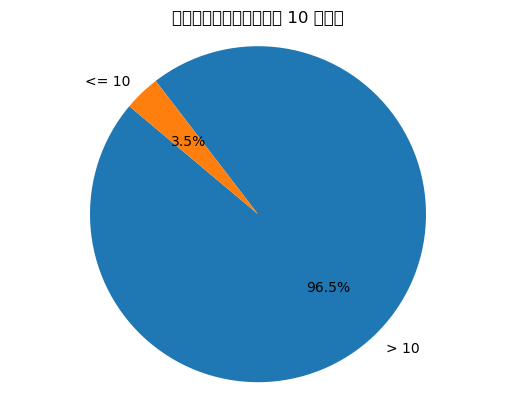

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# 假設這是你的字串陣列

# 計算每個字串的長度
lengths = [len(s) for s in data_list]

# 設定臨界長度
threshold = 10

# 計算大於和小於等於 threshold 的比例
greater_count = sum(1 for length in lengths if length > threshold)
less_equal_count = sum(1 for length in lengths if length <= threshold)

# 繪製圓餅圖
target = [f'> {threshold}', f'<= {threshold}']
sizes = [greater_count, less_equal_count]

plt.pie(sizes, labels=target, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 確保圓餅圖是圓形
plt.title(f'序列長度大於和小於等於 {threshold} 的比例')
plt.show()

In [9]:
def slice_seq_to_same_length(datas: list, labels: list, length: int):
    train_data = []
    train_label = []
    test_data = []
    test_label = []

    for i in range(len(datas)):
        data = datas[i]
        label = labels[i]
        start = 0
        end = len(data)
        while end - start >= length:
            train_data.append(data[start:start + length])
            train_label.append(label[start:start + length])
            start += length
        if start != end:
            test_data.append(data[start:start + length])
            test_label.append(label[start:start + length])
    return np.array(train_data), np.array(train_label), np.array(test_data, dtype=object), np.array(test_label, dtype=object)


train_data, train_label, test_data, test_label = slice_seq_to_same_length(data_list, label_list, 10)

for data in train_data:
    assert len(data) == 10

train_data.shape, train_label.shape
    

((12309, 10, 6), (12309, 10))

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

In [11]:
class Normalizer():
    def __init__(self, labels):
        self.max_val = labels.max()
        self.min_val = labels.min()
    def normalize(self, target):
        return (target - self.min_val) / (self.max_val - self.min_val)
    def denormalize(self, target):
        return target * (self.max_val - self.min_val) + self.min_val
    
label_normalizer = Normalizer(train_label)

In [12]:
#train_labels_norm = label_normalizer.normalize(train_label)


# 將數據轉換為 PyTorch 張量
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label, dtype=torch.float32)



# 建立 TensorDataset
dataset = TensorDataset(train_data_tensor, train_label_tensor)

# 設定訓練和驗證集的比例，例如 80% 給訓練集，20% 給驗證集
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 建立 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 檢查形狀
for batch_data, batch_labels in train_loader:
    print(f"Batch data shape: {batch_data.shape}, Batch labels shape: {batch_labels.shape}")
    break

Batch data shape: torch.Size([64, 10, 6]), Batch labels shape: torch.Size([64, 10])


In [13]:
# 將數據轉換為 PyTorch 張量列表，保留每個序列的不同長度
test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]
test_label_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_label]

# 建立自定義 Dataset 用於處理不同長度的序列
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 建立 Test Dataset 和 DataLoader
test_dataset = TestDataset(test_data_tensors, test_label_tensors)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 檢查測試資料加載情況
for data, label in test_loader:
    print(f"Data shape: {data[0].shape}, Label shape: {label[0].shape}")
    break

Data shape: torch.Size([6, 6]), Label shape: torch.Size([6])


C:\Users\weiso131\AppData\Local\Temp\ipykernel_27416\2696224944.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]
C:\Users\weiso131\AppData\Local\Temp\ipykernel_27416\2696224944.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_label_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_label]


In [14]:
class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size, input_dim=6):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM層，輸入維度為 input_dim，輸出維度為 hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # 線性層將 LSTM 的輸出映射到標籤空間
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))

    def forward(self, sentence, hidden):
        # sentence 的形狀為 (batch_size, seq_len, input_dim)
        # LSTM 層的輸出 lstm_out 形狀為 (batch_size, seq_len, hidden_dim)
        # 並傳回更新後的隱藏狀態
        lstm_out, hidden = self.lstm(sentence, hidden)

        # 使用線性層將 LSTM 的輸出映射到標籤空間
        tag_space = self.relu(self.linear(self.relu(lstm_out)))

        # tag_space 的形狀為 (batch_size, seq_len, tagset_size)
        return tag_space, hidden

In [17]:
import torch
import torch.optim as optim
import torch.nn as nn

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss / len(train_loader):.4f}")

        # 驗證模型
        valid_loss = validate_model(model, valid_loader, criterion)

# 定義驗證函數
def validate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    error = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += abs(outputs.view(-1) - labels.view(-1)).sum() / inputs.shape[0] / inputs.shape[1]
            total_loss += loss.item()

    print(f"Validation Loss: {total_loss / len(valid_loader):.4f}, valid error: {error / len(valid_loader)}")
    return total_loss


In [18]:
model = LSTMTagger(256, 1)
train_model(model, train_loader, valid_loader, 100)


Epoch [1/100], Training Loss: 253.5308
Validation Loss: 251.3319, valid error: 251.8185577392578
Epoch [2/100], Training Loss: 244.3198
Validation Loss: 237.0252, valid error: 237.50498962402344
Epoch [3/100], Training Loss: 230.8330
Validation Loss: 224.8654, valid error: 225.3321990966797
Epoch [4/100], Training Loss: 219.2224
Validation Loss: 214.2641, valid error: 214.71572875976562
Epoch [5/100], Training Loss: 208.4891
Validation Loss: 204.6267, valid error: 205.09397888183594
Epoch [6/100], Training Loss: 201.8168
Validation Loss: 196.0761, valid error: 196.51744079589844
Epoch [7/100], Training Loss: 192.9746
Validation Loss: 188.5858, valid error: 189.01638793945312
Epoch [8/100], Training Loss: 184.7717
Validation Loss: 180.6387, valid error: 181.07936096191406
Epoch [9/100], Training Loss: 176.8427
Validation Loss: 173.6798, valid error: 174.10862731933594
Epoch [10/100], Training Loss: 171.2316
Validation Loss: 166.5855, valid error: 167.0147705078125
Epoch [11/100], Traini

In [21]:
criterion = nn.SmoothL1Loss()
model = model.to(device='cuda', dtype=torch.float32)
validate_model(model, test_loader, criterion=criterion)

Validation Loss: 8.6746, valid error: 8.801407814025879


16108.643337847147

In [24]:
model = model.to(device='cpu')
test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]

for x, y in test_loader:

    with torch.no_grad():
        hidden = model.init_hidden(batch_size=x.size(0))
        predict, _ = model(x, hidden)

        predict_print = (torch.round(predict * 100) / 100).numpy()
        #predict_print = label_normalizer.denormalize(predict_print)
        y_print = (torch.round(y * 100) / 100).numpy()
        np.set_printoptions(precision=2, suppress=True)
        if max(y_print[0]) > 30:

            print("predict:", predict_print[0, :, 0])
            print("label:", y_print[0])
            print()


C:\Users\weiso131\AppData\Local\Temp\ipykernel_27416\2559014824.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]


predict: [ 78.87 129.09]
label: [218.31 266.07]

predict: [52.05 49.55]
label: [50.45 49.45]

predict: [36.21 49.19 92.84]
label: [ 42.1   46.96 129.34]

predict: [ 49.64  75.05 157.85 315.27]
label: [151.32 200.78 289.72 329.45]

predict: [32.78 42.06 37.17 44.52]
label: [32.9  41.2  37.81 44.17]

predict: [49.29 56.19 73.24 90.45]
label: [ 65.54  71.19 107.42 104.77]

predict: [24.34 41.61 55.89 38.45 20.98]
label: [26.4  43.1  57.32 41.   20.5 ]

predict: [ 33.42  41.28  37.92 172.15 236.78]
label: [110.76  92.75  43.95 225.54 177.4 ]

predict: [  9.69  19.89  61.19 145.39 240.2 ]
label: [ 46.38  64.39 135.03 265.85 379.54]

predict: [  7.34  38.62  80.54 237.09 427.43]
label: [ 63.64 110.74  73.81 205.81 312.6 ]

predict: [ 42.98 184.23 208.74 279.35]
label: [101.57 153.07 223.97 315.16]

predict: [ 47.06 185.22 218.09 317.08]
label: [103.16 150.12 210.63 320.74]

predict: [ 55.38 191.47 218.77 304.54]
label: [109.34 160.81 238.36 334.18]

predict: [ 67.81 211.27 245.47 343.69]
lab